# Exercise 4

## Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [3]:
criterion = nn.NLLLoss()   # 或者 nn.CrossEntropyLoss()

# 设备设置，一定要先定义 use_cuda，才能用它来创建 device
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [4]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    
    device = torch.device("cuda" if use_cuda else "cpu")
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()           
        output = model(data)            
        loss = criterion(output, target)
        loss.backward()                 
        optimizer.step()                

        
        total_loss += loss.item() * data.size(0)
       
        pred = output.argmax(dim=1, keepdim=False)
        correct += pred.eq(target).sum().item()
        total += data.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy
        

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [5]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics

    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)

    # if using GPU, move model there
    if use_cuda:
        model = model.cuda()

    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0

    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                data = data.cuda()
                target = target.cuda()

            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1)  # get the index of the max log-probability

            correct += pred.eq(target).sum().item()

            # plot the first 100 images
            data_np = data.cpu().numpy()
            img_correct = pred.eq(target).cpu().numpy()

            img_idx = 0
            while plotted < 100 and img_idx < data_np.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10

                # normalize to [0,1]
                img = data_np[img_idx, 0]
                img = (img - img.min()) / (img.max() - img.min())

                # expand to RGB and color wrong preds red
                img_rgb = np.stack([img]*3, 2)
                if not img_correct[img_idx]:
                    img_rgb[:, :, 1:] = 0.0

                axis[y][x].axis('off')
                axis[y][x].imshow(img_rgb)
                axis[y][x].text(30, 25, str(pred[img_idx].item()), color='w')

                plotted += 1
                img_idx += 1

    # finalize loss/accuracy
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # show all 100 at once
    plt.tight_layout()
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = self.fc5(x)            
        return F.log_softmax(x, dim=1)

In [8]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)


In [9]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.bn3 = nn.BatchNorm1d(60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)


## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [10]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)   # 1×28×28 → 32×26×26
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)  # 32×26×26 → 64×12×12
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [11]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 64*12*12)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [12]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)   # →32×26×26
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)  # →64×24×24
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)       # →64×12×12
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


Test set: Average loss: 0.1513, Accuracy: 9578/10000 (95.78%)



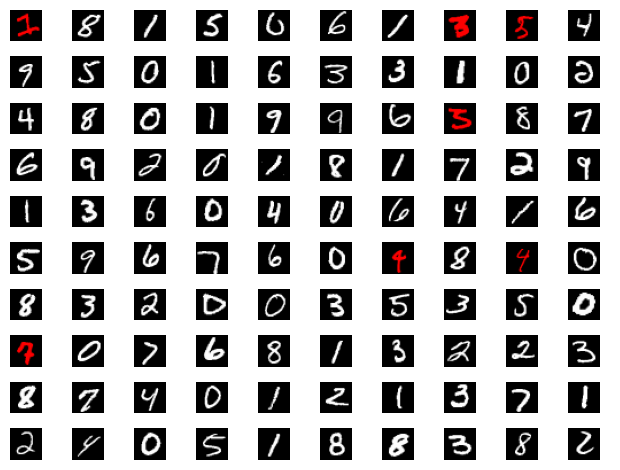


Test set: Average loss: 0.0889, Accuracy: 9760/10000 (97.60%)



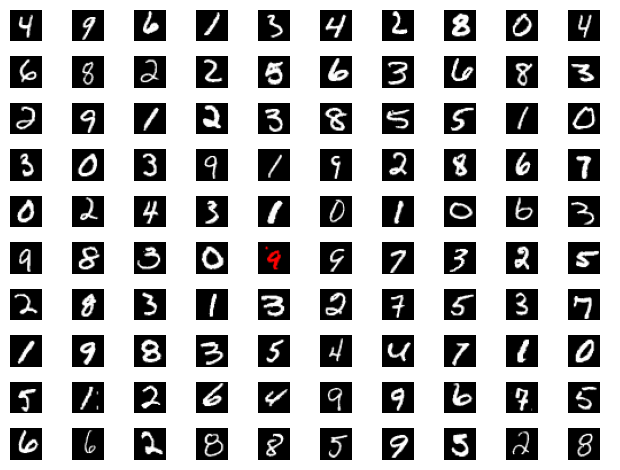


Test set: Average loss: 0.0778, Accuracy: 9797/10000 (97.97%)



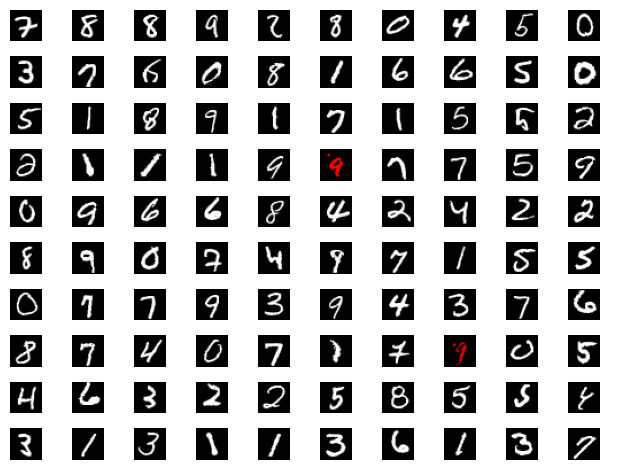


Test set: Average loss: 0.0797, Accuracy: 9805/10000 (98.05%)



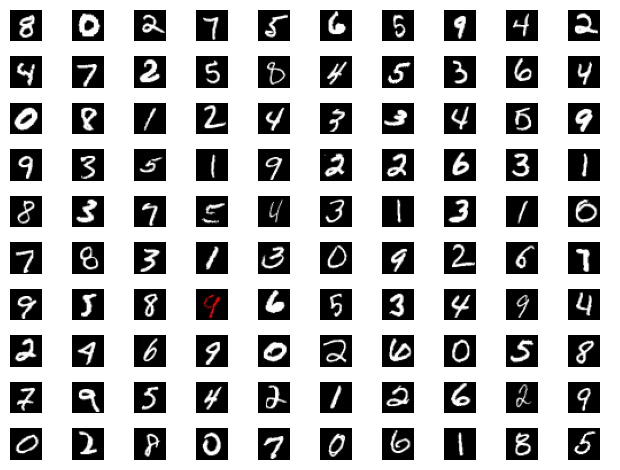


Test set: Average loss: 0.0834, Accuracy: 9814/10000 (98.14%)



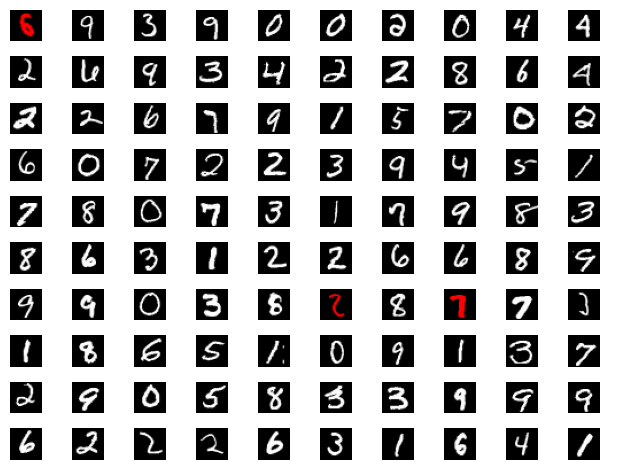


Test set: Average loss: 0.0823, Accuracy: 9824/10000 (98.24%)



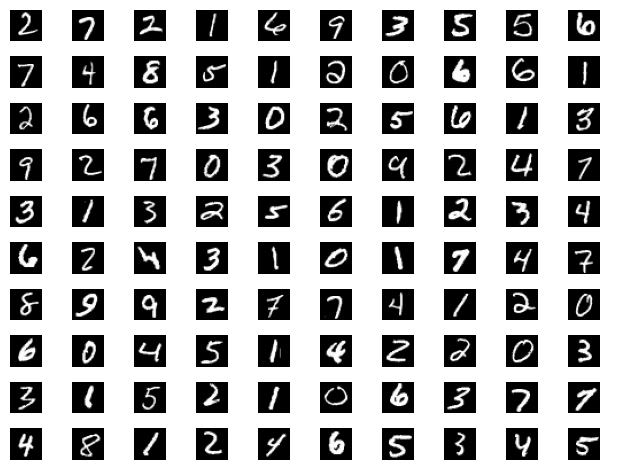


Test set: Average loss: 0.0872, Accuracy: 9822/10000 (98.22%)



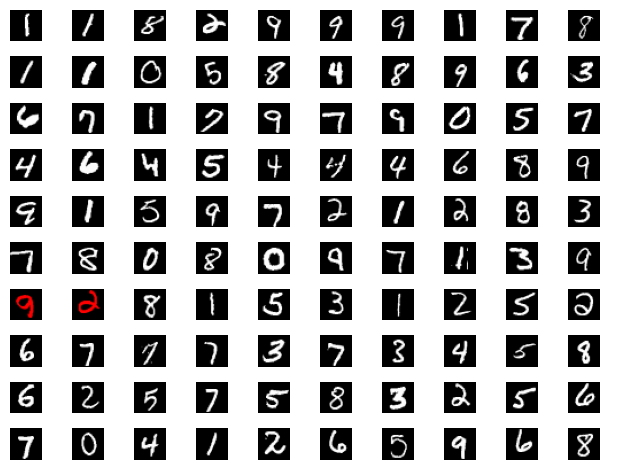


Test set: Average loss: 0.0879, Accuracy: 9827/10000 (98.27%)



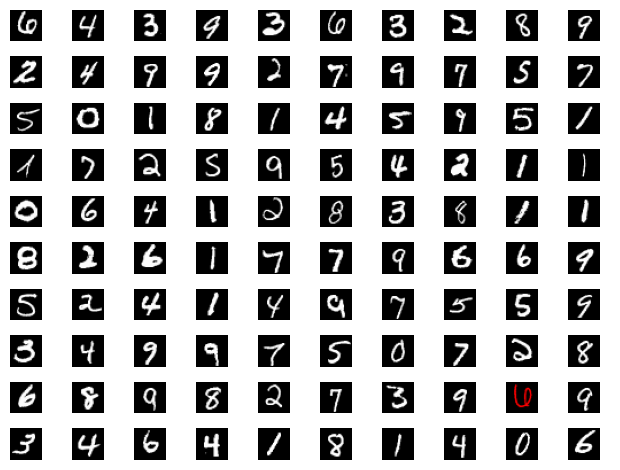


Test set: Average loss: 0.0898, Accuracy: 9826/10000 (98.26%)



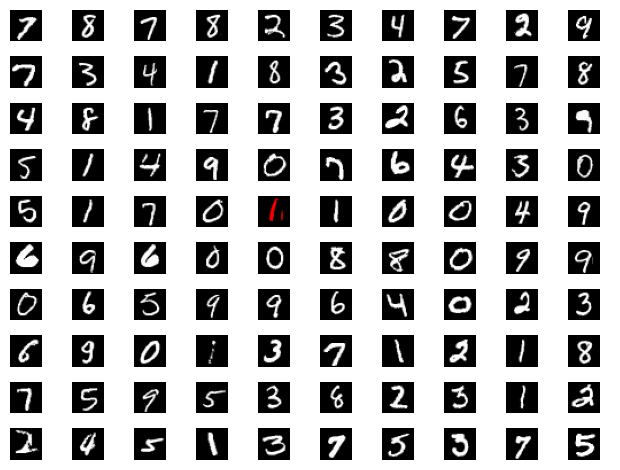


Test set: Average loss: 0.0906, Accuracy: 9825/10000 (98.25%)



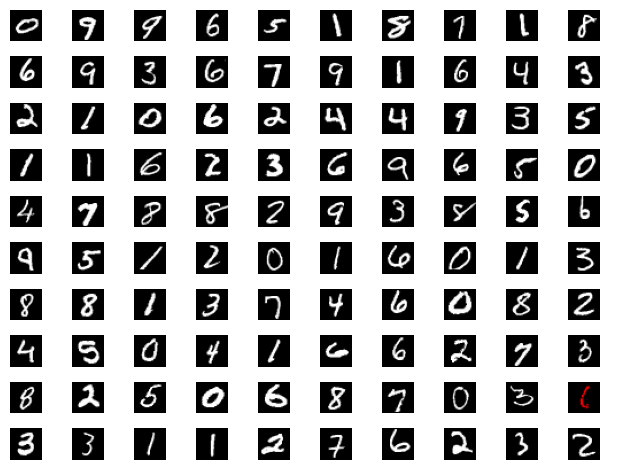

In [13]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")